In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from itertools import combinations
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import random
from itertools import chain
from sklearn.metrics import pairwise_distances
random_state=42
random.seed(random_state)

In [2]:
twenty_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=random_state, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=random_state, remove=('headers', 'footers', 'quotes'))

[]

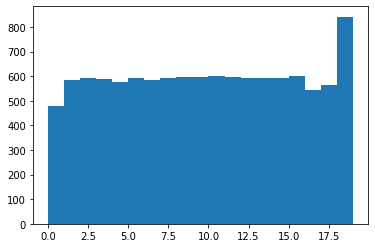

In [3]:
plt.hist(twenty_train.target, bins=np.arange(len(twenty_train.target_names)))
plt.plot()

In [4]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)

tf_transformer = TfidfTransformer(sublinear_tf=True, use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)

In [5]:
svd = TruncatedSVD(n_components=128, n_iter=5, random_state=random_state, algorithm="randomized")
X_train_lsa = svd.fit_transform(X_train_tfidf)
X_train_lsa = normalize(X_train_lsa, norm='l2', axis=1)

In [6]:
# random documents of each news group

# On choisit une news au hasard pour chaque sujet
def sample_each(index_target, sample_id, nb_to_select=1):    
    return list(chain.from_iterable([filter_select(index_target, i, nb_to_select) for i in sample_id]))

# On choisit une parmis les celle qui ont le bon sujet
def filter_select(index_target, by, nb_to_select=1):
    filtered = tuple(filter(lambda i_t : i_t[1]==by, index_target))
    return random.choices(filtered, k=nb_to_select)

index_target = list(enumerate(twenty_train.target))
random_indexes = list(map(lambda p : p[0], sample_each(index_target, list(range(len(twenty_train.target_names))))))
lsa_to_test = zip(random_indexes,X_train_lsa[random_indexes])


In [7]:
# On trie par distance cosinus
def nearest(corpus, lsa, to_test):
    close_index = sorted(range(len(lsa)), key=lambda i : 1 - np.dot(to_test,lsa[i])/np.linalg.norm(to_test)*np.linalg.norm(lsa[i]))    
    return close_index, [corpus[i] for i in close_index]


corpus = list() #Les textes triés par distance cosinus
indexes = list() #Les indexes triés par distance cosinus
target = list() #News à tester
for indexes_to_test, to_test in lsa_to_test:
    target.append(twenty_train.data[indexes_to_test])
    indexes_sorted_by_cosine, corpus_sorted_by_cosine = nearest(twenty_train.data, X_train_lsa, to_test)
    indexes.append(indexes_sorted_by_cosine)
    corpus.append(corpus_sorted_by_cosine)

In [8]:
print("Target:________________________")
print(target[0],'\n')

print("Predicted:_____________________")
print(corpus[0][:1][0])

"""
On retrouve la même news, logique.
"""

Target:________________________



Correction: _hard_ atheism is a faith.



Get a grip, man.  The Stalin example was brought up not as an
indictment of atheism, but merely as another example of how people will
kill others under any name that's fit for the occasion.



So hard atheism has nothing to prove?  Then how does it justify that
God does not exist?  I know, there's the FAQ, etc.  But guess what -- if
those justifications were so compelling why aren't people flocking to
_hard_ atheism?  They're not, and they won't.  I for one will discourage
people from hard atheism by pointing out those very sources as reliable
statements on hard atheism.

Second, what makes you think I'm defending any given religion?  I'm merely
recognizing hard atheism for what it is, a faith.

And yes, by "we" I am referring to every reader of the post.  Where is the
evidence that the poster stated that he relied upon?

         ^^^^

Bzzt!  By virtue of your innocent little pronoun, "they", you've just issu

'\nOn retrouve la même news, logique.\n'

In [9]:
def PQ_kmeans_centroïdes(slice_size, n_clusters):
    nb_tranche = len(X_train_lsa[0])//slice_size
    X_train_lsa_q = X_train_lsa.reshape(-1,nb_tranche,slice_size)
    kmeans_list = list()
    all_labels = list()


    for i in range(nb_tranche):
        test = X_train_lsa_q[:,i:i+1].reshape(-1,slice_size)
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_jobs=-1).fit(test)
        kmeans_list.append(kmeans)
        labels = kmeans.labels_
        all_labels.append(labels)

    all_labels = np.transpose(np.vstack(tuple(all_labels)))
    return all_labels, kmeans_list



"""
Memoire non compréssé : nb_exemple * nb_coeff_lsa (float-8byte) = 11314 * 128 * 8 = 115.855.36
Memoire compréssé : nb_exemple * label_index (unsigned int / 4-byte) (On peut chosir 1 byte...)
                    + nb_centroïde * taille_tranche * nb_tranche (8-bytes par coeff du centroïde) (double)
                    + nb_centroïde*(nb_centroïde-1)/2 * nb_tranche (8-bytes pour la distance) (double)
                    =  11314 * 4 + 256 * 8 * 16 * 8 + 1/2*(256*255) * 16 =  829.640

Le facteur de compression est de quasiment 14.
"""



'\nMemoire non compréssé : nb_exemple * nb_coeff_lsa (float-8byte) = 11314 * 128 * 8 = 115.855.36\nMemoire compréssé : nb_exemple * label_index (unsigned int / 4-byte) (On peut chosir 1 byte...)\n                    + nb_centroïde * taille_tranche * nb_tranche (8-bytes par coeff du centroïde) (double)\n                    + nb_centroïde*(nb_centroïde-1)/2 * nb_tranche (8-bytes pour la distance) (double)\n                    =  11314 * 4 + 256 * 8 * 16 * 8 + 1/2*(256*255) * 16 =  829.640\n\nLe facteur de compression est de quasiment 14.\n'

In [10]:
# On creer un dictionnaire contenant toutes les distances entre cluster
# la clef est (index_cluster_from, index_cluster_to) trié par ordre croissant

def compute_dist_centers(all_kmeans):
    all_dist = list()
    index_pairs_centers = tuple(combinations(np.arange(len(all_kmeans[0].cluster_centers_)), r=2))
    for km in all_kmeans:
        d = dict()
        pairs_centers = tuple(combinations( km.cluster_centers_, r=2))
        for index_pair_centers, pair_center  in zip(index_pairs_centers, pairs_centers):            
            d[index_pair_centers] = distance.euclidean(pair_center[0], pair_center[1])
        all_dist.append(d)
    return all_dist

def approched_dist(key, all_labels, dist_dicts):
    def cluster_index_to_dist(labels_line):
        res = list()
        for c_lab_key, c_lab, dist_dict in zip(key, labels_line, dist_dicts):
            h = tuple(sorted((c_lab_key,c_lab)))
            val = 0. if c_lab_key==c_lab else dist_dict[h]
            res.append(val)
        return sum(res)
    
    return list(enumerate(np.apply_along_axis(cluster_index_to_dist, 1, all_labels)))
    
    

In [11]:
def recall(predicted, ground_truth):
    assert(len(predicted)==len(ground_truth))
    contains = list(map(lambda x : x in ground_truth, predicted))
    return sum(contains)/len(ground_truth)

In [12]:
def sort_index_with_distance_base_on_PQ(slice_size, n_clusters):
    all_labels, kmeans_list = PQ_kmeans_centroïdes(slice_size,n_clusters)
    dist_dicts = compute_dist_centers(kmeans_list)
    sorted_index = list()

    for i in random_indexes:
        dists = approched_dist(all_labels[i], all_labels, dist_dicts)
        sorted_dist = sorted(dists, key=lambda p:p[1])
        indexes_approched = list(map(lambda p: p[0], sorted_dist))
        sorted_index.append(indexes_approched)
    return sorted_index



In [22]:
sorted_index = sort_index_with_distance_base_on_PQ(8,256)
neighborhood = [8,16,32,64,128,256,512,1024,2048,4096,8192]

means_recall = list()
for n in neighborhood:
    mean_recall = 0
    for i in range(len(indexes)):
        predicted = sorted_index[i]
        ground_truth = indexes[i]
        mean_recall += recall(predicted[:n], ground_truth[:n])/len(indexes)
    means_recall.append(mean_recall)


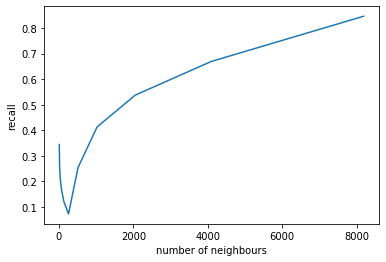

In [23]:
plt.xlabel('number of neighbours')
plt.ylabel('recall')
plt.plot(neighborhood, means_recall)
plt.show()

In [24]:
n = 2048
means_recall = list()
slice_sizes = [2,4,8,16,32,64,128]

for slice_size in slice_sizes:
    mean_recall = 0
    sorted_index = sort_index_with_distance_base_on_PQ(slice_size,256)
    for i in range(len(indexes)):
        predicted = sorted_index[i]
        ground_truth = indexes[i]
        mean_recall += recall(predicted[:n], ground_truth[:n])/len(indexes)
    means_recall.append(mean_recall)


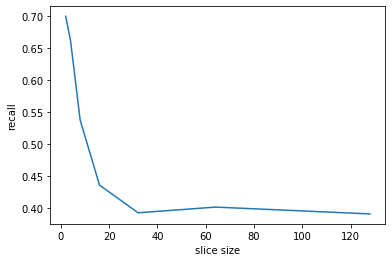

In [25]:
plt.xlabel('slice size')
plt.ylabel('recall')
plt.plot(slice_sizes, means_recall)
plt.show()